# Predicting the NBA All-Stars with Machine Learning

The goal of this analysis is to predict the NBA All-Stars for a given year, based on NBA player data and All-Star selections in other years. This is accomplished by applying several machine learning classification algorithms on NBA player performance data. The analysis is based on the [Scikit-learn](http://scikit-learn.org) machine learning package, NBA player data are taken from [basketball-reference.com](https://www.basketball-reference.com).

## Import modules and libraries:

In [1]:
import NBAanalysissetup # See NBAanalysissetup.py

from NBAanalysissetup import MyModel

import matplotlib.pyplot as plt
import numpy as np
import operator
import pandas as pd
import seaborn as sns
import sys

from IPython.display import display, HTML

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from sklearn.decomposition import PCA
from sklearn.mixture       import GaussianMixture
from sklearn.cluster       import KMeans, SpectralClustering

from sklearn.linear_model          import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier
from sklearn.neighbors             import KNeighborsClassifier
from sklearn.svm                   import LinearSVC #, SVC
from sklearn.tree                  import DecisionTreeClassifier
from sklearn.ensemble              import RandomForestClassifier, ExtraTreesClassifier 
from sklearn.ensemble              import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble              import BaggingClassifier, VotingClassifier
from sklearn.neural_network        import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis #, QuadraticDiscriminantAnalysis
#from sklearn.naive_bayes           import GaussianNB
#from sklearn.gaussian_process      import GaussianProcessClassifier

from sklearn.model_selection import cross_validate, LeaveOneGroupOut

from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

## User input

Choose the year you want to use to run some validation tests (*validation_year*) and the year you want to predict (*prediction_year*), both in range 2000-2018. The years that are not selected for validation tests and prediction are used to train the model.

In [2]:
validation_year = 2017 # Enter any year from 2000 until 2018
prediction_year = 2018 # Enter any year from 2000 until 2018

print("--> Validation_year = {}".format(validation_year))
print("--> Prediction_year = {}".format(prediction_year))

first_year = 2000 # First year for which data has been scraped
last_year  = 2018 # Last  year for which data has been scraped

training_years = list(range(first_year, last_year+1))

training_years.remove(validation_year)
training_years.remove(prediction_year)

first_training_year = training_years[0]
last_training_year  = training_years[-1]
    
if (first_training_year < validation_year < last_training_year) and (first_training_year < prediction_year < last_training_year):
    print("--> Training years  = {}-{} except {} and {}".format(first_training_year, last_training_year, validation_year, prediction_year))
elif (first_training_year < validation_year < last_training_year):
    print("--> Training years  = {}-{} except {}".format(first_training_year, last_training_year, validation_year))
elif (first_training_year < prediction_year < last_training_year):
    print("--> Training years  = {}-{} except {}".format(first_training_year, last_training_year, prediction_year))
else:
    print("--> Training years  = {}-{}".format(first_training_year, last_training_year))

--> Validation_year = 2017
--> Prediction_year = 2018
--> Training years  = 2000-2016


Choose whether you want to include advanced players statistics (e.g. *PER*, *VORP*, etc.) in the model or not,
and choose the minimum number of games a player has to have played in a season to be included in the analysis:

In [3]:
includeadvancedstats = True # Enter True or False

if includeadvancedstats:
    print("--> Advanced statistics included")
else:
    print("--> Advanced statistics not included")
    
min_num_games = 20 # Enter any number between 0 and 82

print("--> Minimum number of games for each player =", min_num_games)

--> Advanced statistics included
--> Minimum number of games for each player = 20


## Load NBA player data:

NBA player data from 2000-2018 from [basketball-reference.com](https://www.basketball-reference.com) have been saved as csv-files in the **data** directory using the scraper functions (*NBA_totals_scraper*, *NBA_advanced_scraper* and *NBA_AllStar_scraper*) in [NBAanalysissetup.py](NBAanalysissetup.py).

In [4]:
df_training, df_validation, df_prediction = \
NBAanalysissetup.loaddata_allyears(prediction_year, validation_year, training_years, includeadvancedstats)

--> Loading   training year 1999-2000 ...
--> Loading   training year 2000-2001 ...
--> Loading   training year 2001-2002 ...
--> Loading   training year 2002-2003 ...
--> Loading   training year 2003-2004 ...
--> Loading   training year 2004-2005 ...
--> Loading   training year 2005-2006 ...
--> Loading   training year 2006-2007 ...
--> Loading   training year 2007-2008 ...
--> Loading   training year 2008-2009 ...
--> Loading   training year 2009-2010 ...
--> Loading   training year 2010-2011 ...
--> Loading   training year 2011-2012 ...
--> Loading   training year 2012-2013 ...
--> Loading   training year 2013-2014 ...
--> Loading   training year 2014-2015 ...
--> Loading   training year 2015-2016 ...
--> Loading validation year 2016-2017 ...
--> Loading prediction year 2017-2018 ...


Print table of All-Stars in *prediction_year*:

In [5]:
print("--> All-Stars {} :".format(prediction_year))
print("")
#tmp = df_training[(df_training['YEAR'] == 2016) & (df_training['AS'] > 0.5)]
tmp = df_prediction[df_prediction['AS'] > 0.5]
display(HTML(tmp.to_html()))

--> All-Stars 2018 :



,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,TW,TC,AS,YEAR
6,LaMarcus Aldridge,C,32,SAS,70,70,2335,638,1253,0.509,27,87,0.310,611,1166,0.524,0.520,315,378,0.833,230,360,590,144,35,84,107,154,1618,24.9,0.570,0.069,0.302,10.9,17.1,14.0,11.5,0.8,3.0,7.0,29.2,6.8,3.4,10.2,0.210,2.9,0.4,3.3,3.1,45,WC,1,2018
15,Giannis Antetokounmpo,PF,23,MIL,72,72,2662,719,1345,0.535,43,133,0.323,676,1212,0.558,0.551,475,628,0.756,154,568,722,345,104,103,212,224,1956,27.7,0.603,0.099,0.467,6.9,25.1,16.0,23.6,2.0,3.3,11.6,31.2,8.5,3.4,11.9,0.215,4.2,1.8,6.0,5.4,41,EC,1,2018
36,Bradley Beal,SG,24,WAS,77,77,2791,644,1399,0.460,187,500,0.374,457,899,0.508,0.527,272,343,0.793,57,281,338,351,94,34,204,146,1747,18.5,0.564,0.357,0.245,2.3,11.4,6.9,21.1,1.7,1.1,11.6,27.8,4.1,2.4,6.5,0.111,2.7,-0.9,1.8,2.7,42,EC,1,2018
78,Jimmy Butler,SG,28,MIN,56,56,2077,417,882,0.473,69,194,0.356,348,688,0.506,0.512,340,393,0.865,75,230,305,279,108,23,103,74,1243,23.5,0.589,0.220,0.446,4.1,12.9,8.5,20.7,2.6,1.0,8.9,24.7,6.8,1.6,8.4,0.194,4.8,0.0,4.9,3.6,44,WC,1,2018
111,DeMarcus Cousins,C,27,NOP,48,48,1737,406,864,0.470,104,294,0.354,302,570,0.530,0.530,294,394,0.746,105,512,617,257,79,76,242,183,1210,22.7,0.583,0.340,0.456,6.8,31.0,19.3,23.2,2.2,3.5,18.9,31.9,1.5,3.1,4.6,0.127,2.0,3.6,5.6,3.3,43,WC,1,2018
119,Stephen Curry,PG,29,GSW,51,51,1631,428,864,0.495,212,501,0.423,216,363,0.595,0.618,278,302,0.921,36,225,261,310,80,8,153,114,1346,28.2,0.675,0.580,0.350,2.7,14.4,9.0,30.2,2.4,0.4,13.3,31.0,7.2,1.9,9.2,0.270,9.8,-1.2,8.6,4.4,56,WC,1,2018
121,Anthony Davis,PF,24,NOP,70,70,2551,729,1362,0.535,52,154,0.338,677,1208,0.560,0.554,455,545,0.835,174,602,776,162,104,174,152,150,1965,28.8,0.613,0.113,0.400,7.7,24.9,16.5,10.9,1.9,5.4,8.7,29.8,8.2,4.4,12.6,0.237,2.9,2.1,5.1,4.5,43,WC,1,2018
129,DeMar DeRozan,SG,28,TOR,75,75,2556,615,1337,0.460,84,270,0.311,531,1067,0.498,0.491,444,539,0.824,56,239,295,390,81,19,167,141,1758,21.4,0.558,0.202,0.403,2.5,10.3,6.5,24.9,1.6,0.6,9.6,29.8,6.7,2.5,9.2,0.173,2.9,-1.0,1.9,2.5,55,EC,1,2018
137,Goran Dragic,PG,31,MIA,72,72,2295,467,1041,0.449,107,292,0.366,360,749,0.481,0.500,214,267,0.801,53,239,292,347,59,12,159,174,1255,16.6,0.542,0.280,0.256,2.6,11.8,7.2,25.5,1.3,0.4,12.1,25.8,2.9,2.2,5.1,0.107,1.1,-1.1,0.0,1.1,41,EC,1,2018
139,Andre Drummond,C,24,DET,75,75,2504,446,845,0.528,0,8,0.000,446,837,0.533,0.528,235,380,0.618,384,814,1198,228,111,124,192,239,1127,23.3,0.557,0.009,0.450,16.5,36.6,26.4,14.5,2.2,4.4,15.9,21.3,4.5,5.6,10.1,0.194,0.3,5.4,5.7,4.9,37,EC,1,2018


Print table of non-All-Stars in *prediction_year*:

Select only players which have played at least *min_num_games* number of games in a season:

In [6]:
print("--> # of players in   training set =", df_training  .shape[0])
print("--> # of players in validation set =", df_validation.shape[0])
print("--> # of players in prediction set =", df_prediction.shape[0])
print("")

df_training   = df_training  [df_training  ['G'] >= min_num_games]
df_validation = df_validation[df_validation['G'] >= min_num_games]
df_prediction = df_prediction[df_prediction['G'] >= min_num_games]

print("--> # of players in   training set =", df_training  .shape[0])
print("--> # of players in validation set =", df_validation.shape[0])
print("--> # of players in prediction set =", df_prediction.shape[0])

--> # of players in   training set = 7754
--> # of players in validation set = 486
--> # of players in prediction set = 531

--> # of players in   training set = 6669
--> # of players in validation set = 413
--> # of players in prediction set = 400


NaN handling:

In [7]:
print("--> # of players with NaNs in   training set =", df_training  .shape[0] - df_training  .dropna().shape[0])
print("--> # of players with NaNs in validation set =", df_validation.shape[0] - df_validation.dropna().shape[0])
print("--> # of players with NaNs in prediction set =", df_prediction.shape[0] - df_prediction.dropna().shape[0])
print("")

# Replace NaNs with 0s in the following columns:

df_training  [['FG%', '3P%', '2P%', 'FT%', 'eFG%']] = df_training  [['FG%', '3P%', '2P%', 'FT%', 'eFG%']].fillna(value=0)
df_validation[['FG%', '3P%', '2P%', 'FT%', 'eFG%']] = df_validation[['FG%', '3P%', '2P%', 'FT%', 'eFG%']].fillna(value=0)
df_prediction[['FG%', '3P%', '2P%', 'FT%', 'eFG%']] = df_prediction[['FG%', '3P%', '2P%', 'FT%', 'eFG%']].fillna(value=0)

if (includeadvancedstats):
    df_training  [['TS%', '3PAr', 'FTr']] = df_training  [['TS%', '3PAr', 'FTr']].fillna(value=0)
    df_validation[['TS%', '3PAr', 'FTr']] = df_validation[['TS%', '3PAr', 'FTr']].fillna(value=0)
    df_prediction[['TS%', '3PAr', 'FTr']] = df_prediction[['TS%', '3PAr', 'FTr']].fillna(value=0)
    
print("--> # of players with NaNs in   training set =", df_training  .shape[0] - df_training  .dropna().shape[0])
print("--> # of players with NaNs in validation set =", df_validation.shape[0] - df_validation.dropna().shape[0])
print("--> # of players with NaNs in prediction set =", df_prediction.shape[0] - df_prediction.dropna().shape[0])
print("")

# Remove remaining players with NaNs, if necessary:

if (df_training.shape[0] - df_training.dropna().shape[0] != 0):
    #print("--> Players in training set with NaNs:")
    #print(df_training[df_training.isnull().any(axis=1)])
    #print("")
    df_training.dropna(inplace=True)
    print("--> # of players with NaNs in   training set =", df_training.shape[0] - df_training.dropna().shape[0])

if (df_validation.shape[0] - df_validation.dropna().shape[0] != 0):
    #print("--> Players in validation set with NaNs:")
    #print(df_validation[df_validation.isnull().any(axis=1)])
    #print("")
    df_validation.dropna(inplace=True)
    print("--> # of players with NaNs in validation set =", df_validation.shape[0] - df_validation.dropna().shape[0])

if (df_prediction.shape[0] - df_prediction.dropna().shape[0] != 0):
    #print("--> Players in prediction set with NaNs:")
    #print(df_prediction[df_prediction.isnull().any(axis=1)])
    #print("")
    df_prediction.dropna(inplace=True)
    print("--> # of players with NaNs in prediction set =", df_prediction.shape[0] - df_prediction.dropna().shape[0])

--> # of players with NaNs in   training set = 806
--> # of players with NaNs in validation set = 21
--> # of players with NaNs in prediction set = 22

--> # of players with NaNs in   training set = 0
--> # of players with NaNs in validation set = 0
--> # of players with NaNs in prediction set = 0



Check number of All-Stars in dataframes:

In [8]:
# Check All-Star data in data files:

all_years = training_years[:]
all_years.append(validation_year)
all_years.append(prediction_year)

n_AS_dict = {} 

for year in all_years:
    shellcommand = "wc -l data/NBA_allstars_{}-{}.csv | awk '{{print $1}}'".format(year-1, year)
    n = !{shellcommand}
    n_AS_dict[year] = int(n[0]) - 1 # Don't count header
    
# Check All-Star data in dataframes:

for year in training_years:
    n_AS_df  = df_training[(df_training['YEAR'] == year) & (df_training['AS'] > 0.5)].shape[0]
    n_AS_tot = n_AS_dict[year]
    n_tot    = df_training[(df_training['YEAR'] == year)].shape[0]
    print("--> Training   year {}: {} out of {} All-Stars in analysis (Total # of players = {})".format(year, n_AS_df, n_AS_tot, n_tot))
    
n_AS_df  = df_validation[df_validation['AS'] > 0.5].shape[0]
n_AS_tot = n_AS_dict[validation_year]
n_tot    = df_validation.shape[0]
print("--> Validation year {}: {} out of {} All-Stars in analysis (Total # of players = {})".format(validation_year, n_AS_df, n_AS_tot, n_tot))

n_AS_df  = df_prediction[df_prediction['AS'] > 0.5].shape[0]
n_AS_tot = n_AS_dict[prediction_year]
n_tot    = df_prediction.shape[0]
print("--> Prediction year {}: {} out of {} All-Stars in analysis (Total # of players = {})".format(prediction_year, n_AS_df, n_AS_tot, n_tot))

--> Training   year 2000: 24 out of 24 All-Stars in analysis (Total # of players = 378)
--> Training   year 2001: 26 out of 28 All-Stars in analysis (Total # of players = 375)
--> Training   year 2002: 26 out of 26 All-Stars in analysis (Total # of players = 379)
--> Training   year 2003: 25 out of 25 All-Stars in analysis (Total # of players = 362)
--> Training   year 2004: 24 out of 24 All-Stars in analysis (Total # of players = 372)
--> Training   year 2005: 24 out of 24 All-Stars in analysis (Total # of players = 388)
--> Training   year 2006: 25 out of 25 All-Stars in analysis (Total # of players = 404)
--> Training   year 2007: 29 out of 29 All-Stars in analysis (Total # of players = 395)
--> Training   year 2008: 26 out of 26 All-Stars in analysis (Total # of players = 385)
--> Training   year 2009: 26 out of 26 All-Stars in analysis (Total # of players = 384)
--> Training   year 2010: 28 out of 28 All-Stars in analysis (Total # of players = 391)
--> Training   year 2011: 24 out

Prepare data and create features (*X*) and target (*y*) dataframes needed for Scikit-learn methods:

In [9]:
# Features dataframes (AS and YEAR are dropped: AS is the target variable, YEAR is only used for cross-validation):

X_training   = df_training.  drop(['AS', 'YEAR'], axis=1)
X_validation = df_validation.drop(['AS', 'YEAR'], axis=1)
X_prediction = df_prediction.drop(['AS', 'YEAR'], axis=1)

X_list = [X_training, X_validation, X_prediction]

for X in X_list:
    
    # Remove features:

    X.drop(['Player', 'Pos', 'Tm', 'Age', 'TC',                             # No predictive power
            'FG', 'FGA', 'FG%', '3P%', '2P%', 'FT%', 'eFG%', 'TRB', 'PTS'], # Correlated with other features
           axis=1, inplace=True)

    if includeadvancedstats:
        X.drop(['TS%', '3PAr', 'FTr', 'TRB%', 'WS', 'WS/48', 'BPM',         # Correlated with other features 
                'ORB', 'DRB', 'AST', 'TOV', 'STL', 'BLK'],                  # Correlated with other features
               axis=1, inplace=True) 
    
    # Replace GS by GS/G, and MP by MP/G:

    X['GS'] = X['GS'].div(X['G'].values, axis=0)
    X['MP'] = X['MP'].div(X['G'].values, axis=0)
    X['TW'] = X['TW'].div(82, axis=0)
    X.rename(columns={'GS': 'GS/G', 'MP': 'MP/G', 'TW': 'TW/82'}, inplace=True)

    '''
    # Scale total-type features by MP/48:

    X[['3P', '3PA', '2P', '2PA', 'FT', 'FTA', 'PF']] = \
    X[['3P', '3PA', '2P', '2PA', 'FT', 'FTA', 'PF']].div(X['MP/48'].values, axis=0)
    X.rename(columns={'3P': '3P/48', '3PA': '3PA/48', 'FT': 'FT/48', 'FTA': 'FTA/48', 
                      '2P': '2P/48', '2PA': '2PA/48', 'PF': 'PF/48'}, inplace=True)
    
    if includeadvancedstats:
        X[['OWS', 'DWS']] = \
        X[['OWS', 'DWS']].div(X['MP/48'].values, axis=0)
        X.rename(columns={'OWS': 'OWS/48', 'DWS': 'DWS/48'}, inplace=True)
    else:
        X[['ORB', 'DRB', 'AST', 'STL', 'BLK', 'TOV', 'PF']] = \
        X[['ORB', 'DRB', 'AST', 'STL', 'BLK', 'TOV', 'PF']].div(X['MP/48'].values, axis=0)
        X.rename(columns={'ORB': 'ORB/48', 'DRB': 'DRB/48', 'AST': 'AST/48', 'PF': 'PF/48',
                          'BLK': 'BLK/48', 'TOV': 'TOV/48', 'STL': 'STL/48'}, inplace=True)
    '''
    
# Target dataframes (target = AS, a binary variable introduced to indicate All-Star status):

y_training   = df_training  ['AS']
y_validation = df_validation['AS']
y_prediction = df_prediction['AS']

print("--> Training   data set      : # of players = {:4}, # of features = {}".format(X_training.shape[0], X_training.shape[1]))
print("--> Validation data set {} : # of players = {:4}, # of features = {}".format(validation_year, X_validation.shape[0], X_validation.shape[1]))
print("--> Prediction data set {} : # of players = {:4}, # of features = {}".format(prediction_year, X_prediction.shape[0], X_prediction.shape[1]))
print("")

print("--> Model features : ", list(X_training.columns))

--> Training   data set      : # of players = 6669, # of features = 24
--> Validation data set 2017 : # of players =  413, # of features = 24
--> Prediction data set 2018 : # of players =  400, # of features = 24

--> Model features :  ['G', 'GS/G', 'MP/G', '3P', '3PA', '2P', '2PA', 'FT', 'FTA', 'PF', 'PER', 'ORB%', 'DRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'OBPM', 'DBPM', 'VORP', 'TW/82']


Scale features so they have zero mean and unit variance:

In [10]:
features = X_training.columns # since this is no longer available after transformation with scaler

#X_scaler = StandardScaler(with_mean=True, with_std=True) # Scaler with zero mean and unit variance
#X_scaler = MinMaxScaler() # Scales features to range 0 to 1 (or -1 to 1 if there are negative values)
X_scaler = RobustScaler() # Similar method to the MinMaxScaler but more robust to outliers

X_training = X_scaler.fit_transform(X_training) # Fit scaler to training data and transform X_training

X_validation = X_scaler.transform(X_validation) # Transform X_validation using fitted scaler
X_prediction = X_scaler.transform(X_prediction) # Transform X_prediction using fitted scaler

Plot a few potentially interesting feature distributions in training data:

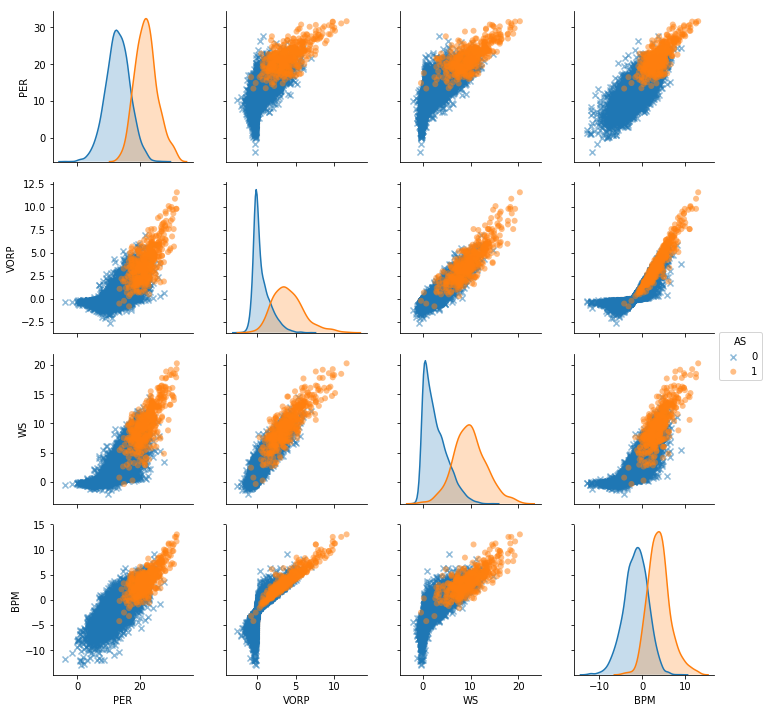

In [11]:
if includeadvancedstats:
    plotvariables = ['PER', 'VORP', 'WS', 'BPM']
else:
    plotvariables = ['PTS', 'eFG%', 'MP']

_ = sns.pairplot(df_training, vars=plotvariables, hue="AS",
                 diag_kind="kde", diag_kws=dict(shade=True),
                 markers = ['x','o'], plot_kws=dict(edgecolor="none", alpha=0.5))

## Unsupervised Learning: PCA & Clustering

Use Principal Component Analysis for dimensionality reduction and plot result:

--> Training data in the PCA1-PCA2 plane, where PCA1 and PCA2 represent the
    two principal axes in feature space of maximum variance in the data:


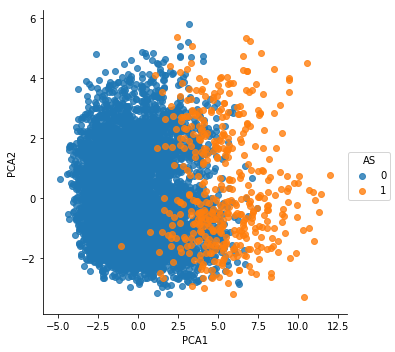

In [12]:
model = PCA(n_components=2, svd_solver='randomized') # Instantiate PCA model with hyperparameters

model.fit(X_training)                                # Fit model to data. Notice y is not specified!

X_2D = model.transform(X_training)                   # Transform the data to two dimensions

df_training['PCA1'] = X_2D[:, 0] 
df_training['PCA2'] = X_2D[:, 1]

print("--> Training data in the PCA1-PCA2 plane, where PCA1 and PCA2 represent the")
print("    two principal axes in feature space of maximum variance in the data:")

_ = sns.lmplot("PCA1", "PCA2", data=df_training, hue='AS', fit_reg=False)

Apply clustering algorithms to identify clusters in the training data and plot clusters:

--> KMeans clusters:


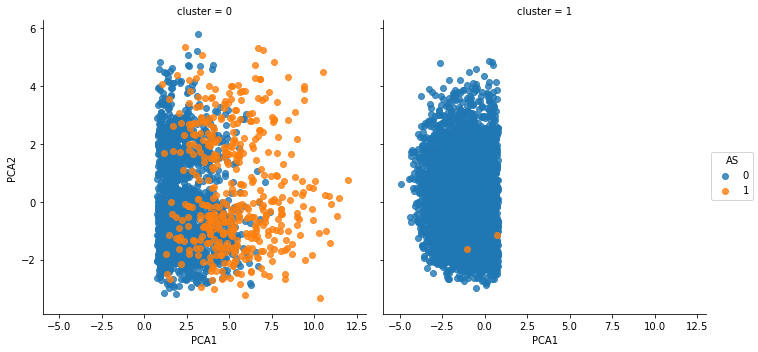

--> Gaussian Mixture clusters:


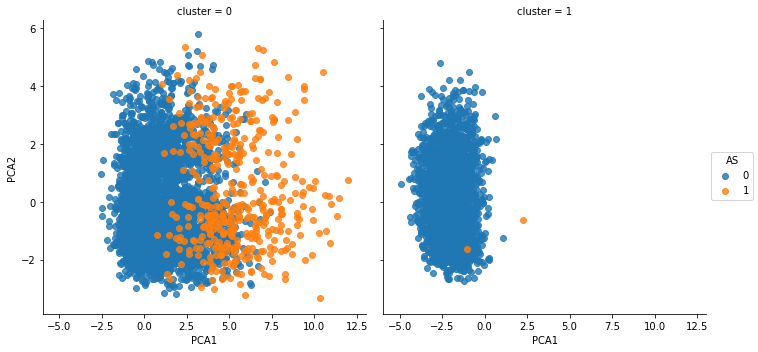

--> Spectral Clustering clusters:


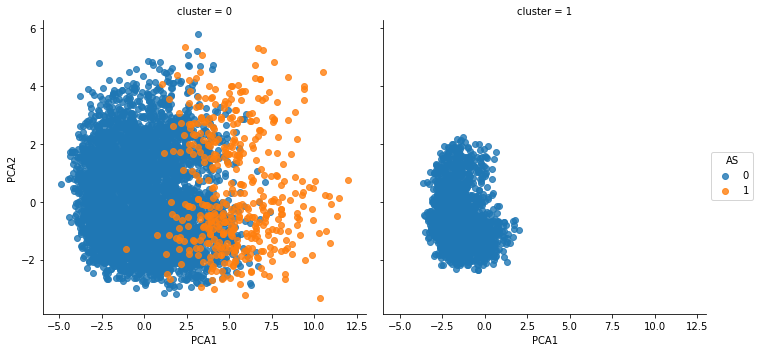

In [13]:
cluster_models = []

modelname = 'KMeans'
model = KMeans(n_clusters=2, init='random')                      # Instantiate model with hyperparameters
cluster_models.append((modelname, model))

modelname = 'Gaussian Mixture'
model = GaussianMixture(n_components=2, covariance_type='full')  # Instantiate model with hyperparameters
cluster_models.append((modelname, model))

modelname = 'Spectral Clustering'
model = SpectralClustering(n_clusters=2)                         # Instantiate model with hyperparameters
cluster_models.append((modelname, model))

for model in cluster_models:
                      
    model[1].fit(X_training)                                     # Fit model to data. Notice y is not specified!
    
    if hasattr(model[1], 'labels_'):                             # Determine cluster labels
        y_pred = model[1].labels_.astype(np.int)
    else:
        y_pred = model[1].predict(X_training)

    df_training['cluster'] = y_pred

    print("-->", model[0], "clusters:")
    sns.lmplot("PCA1", "PCA2", data=df_training, hue='AS', col='cluster', fit_reg=False)
    plt.show()

## Supervised Learning: Classification

Select ML classifiers, set hyper-parameters and instantiate models:

In [14]:
rseed = 666 # Set random_state of model (where applicable) to specific seed, to tune hyper-parameters

mymodels   = []
modelnames = []

modelname = 'Logistic Regression Classifier' # 0
modelnames.append(modelname)
C = 100  # A smaller value for C results in more regularization (variance reduction due to noise in data)
p = 'l2' # penalty="l1" enables Lasso regularization (i.e. sparsity)  => Feature selection, 
#          penalty="l2" enables Ridge regularization (i.e. shrinkage) => Coefficient suppression
model = LogisticRegression(C=C, penalty=p)
mymodels.append(MyModel(modelname, model))

modelname = 'Nearest Neighbours Classifier' # 1 (CV is slowww)
modelnames.append(modelname)
n_n = 5
w   = 'uniform' # 'distance'
model = KNeighborsClassifier(n_neighbors=n_n, weights=w)
mymodels.append(MyModel(modelname, model))

#modelname = 'Support Vector Machine Classifier' # 2
modelname = 'Linear Support Vector Machine Classifier' # 2
modelnames.append(modelname)
#k = 'rbf' # 'linear' # 'poly', 'rbf'
#d = 3 # for kernel='poly'
C = 1
p = 'l2'
#model = SVC(kernel=k, degree=d, probability=True, C=C, random_state=rseed)
model = LinearSVC(C=C, penalty=p, dual=False)
mymodels.append(MyModel(modelname, model))

modelname = 'Stochastic Gradient Descent Classifier' # 3
modelnames.append(modelname)
l = 'hinge' # 'log', 'modified_huber', 'squared_hinge', 'perceptron'
p = 'l2' # penalty="l1" enables Lasso regularization (i.e. sparsity), 
#          penalty="l2" enables Ridge regularization (i.e. shrinkage)
model = SGDClassifier(loss=l, penalty=p, random_state=rseed)
mymodels.append(MyModel(modelname, model))

#modelname = 'Decision Tree Classifier' # 4
modelname = 'Bagged Decision Tree Classifier' # 4
modelnames.append(modelname)
m_d = None
m_f = 'auto'
#model = DecisionTreeClassifier(max_depth=m_d, max_features=m_f, class_weight='balanced', random_state=rseed)
dtc = DecisionTreeClassifier(max_depth=m_d, max_features=m_f, random_state=rseed)
model = BaggingClassifier(base_estimator=dtc, random_state=rseed)
mymodels.append(MyModel(modelname, model))

modelname = 'Random Forest Classifier' # 5
modelnames.append(modelname)
n_e = 100
m_d = None   # i.e. nodes are expanded until leafs are pure 
m_f = 'auto' # The number of features to consider when looking for the best split. 
#              'auto' => max_features=sqrt(n_features) 
model = RandomForestClassifier(n_estimators=n_e, max_depth=m_d, max_features=m_f, class_weight='balanced', random_state=rseed)
mymodels.append(MyModel(modelname, model))

modelname = 'Extremely Randomized Trees Classifier' # 6
modelnames.append(modelname)
n_e = 100
m_d = None
m_f = 'auto'
model = ExtraTreesClassifier(n_estimators=n_e, max_depth=m_d, max_features=m_f, class_weight='balanced', random_state=rseed)
mymodels.append(MyModel(modelname, model))

modelname = 'Gradient Boost Classifier' # 7
modelnames.append(modelname)
n_e = 100
m_d = 3
l_l = 0.1
model = GradientBoostingClassifier(n_estimators=n_e, max_depth=m_d, learning_rate=l_l, random_state=rseed)
mymodels.append(MyModel(modelname, model))

modelname = 'AdaBoost Classifier' # 8
modelnames.append(modelname)
n_e = 100
l_l = 0.1
model = AdaBoostClassifier(n_estimators=n_e, learning_rate=l_l, random_state=rseed)
mymodels.append(MyModel(modelname, model))

modelname = 'Neural Network Classifier' # 9
modelnames.append(modelname)
a = 0.0001 # L2 penalty (regularization term) parameter
model = MLPClassifier(alpha=a, random_state=rseed)
mymodels.append(MyModel(modelname, model))

#modelname = 'Quadratic Discriminant Analysis Classifier' # 10
modelname = 'Linear Discriminant Analysis Classifier' # 10
modelnames.append(modelname)
#model = QuadraticDiscriminantAnalysis()
so = 'svd' # 'lsqr', 'eigen' (if 'svd', shrinkage should be None)
sh = None # 'auto' 
model = LinearDiscriminantAnalysis(solver=so, shrinkage=sh)
mymodels.append(MyModel(modelname, model))

'''
modelname = 'Gaussian Process Classifier'  # 11 (CV is slowwwwwwww)
modelnames.append(modelname)
model = GaussianProcessClassifier(random_state=rseed)
mymodels.append(MyModel(modelname, model))

modelname = 'Gaussian Naive Bayes Classifier' # 12 (Assumes Gaussian PDFs for feature distributions)
modelnames.append(modelname)
model = GaussianNB()
mymodels.append(MyModel(modelname, model))
'''

modelname = 'Passive Aggressive Classifier' # 13
modelnames.append(modelname)
C = 0.001
l = 'squared_hinge' # 'hinge'
model = PassiveAggressiveClassifier(C=C, loss=l, random_state=rseed)
mymodels.append(MyModel(modelname, model))

modelname = 'Voting Classifier' # 14
modelnames.append(modelname)
classification_algs = []
for counter, mymodel in enumerate(mymodels, 1):
    #if (0 < counter < 10):
    clf_tuple = (mymodel.name, mymodel.classifier)
    classification_algs.append(clf_tuple)
    
model = VotingClassifier(estimators=classification_algs, voting='hard')
mymodels.append(MyModel(modelname, model))

print("--> ML classifiers implemented in this analysis:")
print("")

for counter, mymodel in enumerate(mymodels, 1):
    print("{:2} : {}".format(counter, mymodel.name))

--> ML classifiers implemented in this analysis:

 1 : Logistic Regression Classifier
 2 : Nearest Neighbours Classifier
 3 : Linear Support Vector Machine Classifier
 4 : Stochastic Gradient Descent Classifier
 5 : Bagged Decision Tree Classifier
 6 : Random Forest Classifier
 7 : Extremely Randomized Trees Classifier
 8 : Gradient Boost Classifier
 9 : AdaBoost Classifier
10 : Neural Network Classifier
11 : Linear Discriminant Analysis Classifier
12 : Passive Aggressive Classifier
13 : Voting Classifier


## Cross-validation

Cross-validate the model using training data and the *LeaveOneGroupOut* cross-validation scheme in which a group is defined as a single NBA season, and calculate some model scores:

In [15]:
#note1 = " (Answers the question: How many predicted All-Stars are true All-Stars?)"
#note2 = " (Answers the question: How many true All-Stars have been predicted?)"
#note3 = " (i.e. the harmonic mean of Precision and Recall)"
#note4 = " (Answers the question: How many AS and non-AS have been correctly predicted?)"

logo = LeaveOneGroupOut()

scoring_list = ['precision', 'recall', 'f1', 'accuracy']

cv_groups = df_training['YEAR'] # Players in the same group (i.e. a single NBA season) have identical YEAR variables

cv_scores_list = []

for mymodel in mymodels:
    
    mymodel.reset()
    
    model     = mymodel.classifier
    modelname = mymodel.name

    print("--> Cross-validating", modelname, "...")
    #print("")
            
    cv_logo = logo.split(X_training, y_training, groups=cv_groups)

    scores = cross_validate(model, X_training, y_training, cv=cv_logo, scoring=scoring_list); #, n_jobs=-1)

    [mymodel.add_year_train_score(i)      for i in training_years          ] 
    [mymodel.add_precision_train_score(i) for i in scores['test_precision']]
    [mymodel.add_recall_train_score(i)    for i in scores['test_recall'   ]]
    [mymodel.add_f1_train_score(i)        for i in scores['test_f1'       ]]
    [mymodel.add_accuracy_train_score(i)  for i in scores['test_accuracy' ]]
    
    cv_scores_list.append({'Estimator'      : modelname, 
                           'Precision mean' : mymodel.precision_train_scores_mean .round(3)*100, 
                           'Precision std'  : mymodel.precision_train_scores_std  .round(3)*100, 
                           'Recall mean'    : mymodel.recall_train_scores_mean    .round(3)*100, 
                           'Recall std'     : mymodel.recall_train_scores_std     .round(3)*100, 
                           'F1 mean'        : mymodel.f1_train_scores_mean        .round(3)*100, 
                           'F1 std'         : mymodel.f1_train_scores_std         .round(3)*100, 
                           'Accuracy mean'  : mymodel.accuracy_train_scores_mean  .round(3)*100, 
                           'Accuracy std'   : mymodel.accuracy_train_scores_std   .round(3)*100})
    
    '''
    print("--> Cross-val years  :", ["{:6d}".format(i) for i in mymodel.year_train_scores])
    print("")
    print("--> Precision scores :", ["{:6.1%}".format(i) for i in mymodel.precision_train_scores])
    print("--> Recall    scores :", ["{:6.1%}".format(i) for i in mymodel.recall_train_scores   ])
    print("--> F1        scores :", ["{:6.1%}".format(i) for i in mymodel.f1_train_scores       ])
    print("--> Accuracy  scores :", ["{:6.1%}".format(i) for i in mymodel.accuracy_train_scores ])
    print("")
    print("--> Precision score : {:5.1%} +/- {:5.1%}".format(mymodel.precision_train_scores_mean,
                                                             mymodel.precision_train_scores_std) + note1)
    print("--> Recall score    : {:5.1%} +/- {:5.1%}".format(mymodel.recall_train_scores_mean,
                                                             mymodel.recall_train_scores_std)    + note2)
    print("--> F1 score        : {:5.1%} +/- {:5.1%}".format(mymodel.f1_train_scores_mean,
                                                             mymodel.f1_train_scores_std)        + note3)
    print("--> Accuracy score  : {:5.1%} +/- {:5.1%}".format(mymodel.accuracy_train_scores_mean,
                                                             mymodel.accuracy_train_scores_std)  + note4)
    print("")
    '''

print("")
print("--> Cross-validation scores for all models (mean and std over all years):")
print("")

columnorder = ['Estimator', 'Precision mean', 'Precision std', 'Recall mean', 'Recall std', 
               'F1 mean', 'F1 std', 'Accuracy mean', 'Accuracy std']

df_cv_scores = pd.DataFrame(cv_scores_list, columns=columnorder)

display(HTML(df_cv_scores.to_html()))

--> Cross-validating Logistic Regression Classifier ...
--> Cross-validating Nearest Neighbours Classifier ...
--> Cross-validating Linear Support Vector Machine Classifier ...
--> Cross-validating Stochastic Gradient Descent Classifier ...
--> Cross-validating Bagged Decision Tree Classifier ...
--> Cross-validating Random Forest Classifier ...
--> Cross-validating Extremely Randomized Trees Classifier ...
--> Cross-validating Gradient Boost Classifier ...
--> Cross-validating AdaBoost Classifier ...
--> Cross-validating Neural Network Classifier ...
--> Cross-validating Linear Discriminant Analysis Classifier ...
--> Cross-validating Passive Aggressive Classifier ...
--> Cross-validating Voting Classifier ...

--> Cross-validation scores for all models (mean and std over all years):



,Estimator,Precision mean,Precision std,Recall mean,Recall std,F1 mean,F1 std,Accuracy mean,Accuracy std
0,Logistic Regression Classifier,81.6,6.3,72.1,9.1,76.0,5.0,97.1,0.5
1,Nearest Neighbours Classifier,83.2,5.7,65.6,11.3,72.7,7.7,96.9,0.7
2,Linear Support Vector Machine Classifier,82.5,6.4,71.7,9.3,76.2,5.6,97.1,0.5
3,Stochastic Gradient Descent Classifier,81.0,12.2,69.7,11.9,73.3,5.0,96.7,0.7
4,Bagged Decision Tree Classifier,86.8,7.2,62.7,10.4,72.2,7.1,96.9,0.7
5,Random Forest Classifier,84.6,7.4,60.3,7.6,69.8,4.9,96.6,0.5
6,Extremely Randomized Trees Classifier,87.6,7.5,61.7,9.6,71.5,5.8,96.9,0.5
7,Gradient Boost Classifier,81.2,9.5,70.8,8.6,75.1,5.8,96.9,0.7
8,AdaBoost Classifier,83.2,6.3,66.5,10.1,73.4,7.1,96.9,0.7
9,Neural Network Classifier,80.6,5.8,70.8,10.5,74.8,5.8,96.9,0.6


## Model training

Fit models to training data, use fitted models to predict validation data and calculate the corresponding confusion matrices and some model scores:

In [16]:
validation_scores_list = []

for mymodel in mymodels:
    
    model     = mymodel.classifier
    modelname = mymodel.name

    print("--> Fitting", modelname, "...")
    #print("")
    
    model.fit(X_training, y_training)     # Fit model to training data

    y_model = model.predict(X_validation) # Predict validation data

    y_true = y_validation.tolist()

    CM = confusion_matrix(y_true, y_model) # defined as: rows -> true, columns -> prediction

    mymodel.set_CM(CM)

    validation_scores_list.append({'Estimator' : modelname, 
                                   'TP'        : mymodel.TP, 
                                   'FP'        : mymodel.FP, 
                                   'FN'        : mymodel.FN, 
                                   'TN'        : mymodel.TN, 
                                   'Precision' : mymodel.precision.round(3)*100, 
                                   'Recall'    : mymodel.recall.round(3)*100, 
                                   'F1'        : mymodel.f1.round(3)*100, 
                                   'Accuracy'  : mymodel.accuracy.round(3)*100,
                                   'TPR'       : mymodel.tpr.round(3)*100,
                                   'FPR'       : mymodel.fpr.round(3)*100})
    '''
    print("--> Confusion matrix {}:".format(validation_year))
    print(CM)
    print("")

    TN = CM[0,0] # defined as: 0 = negative, 1 = positive
    FN = CM[1,0] # defined as: 0 = negative, 1 = positive
    FP = CM[0,1] # defined as: 0 = negative, 1 = positive
    TP = CM[1,1] # defined as: 0 = negative, 1 = positive

    TOT = TP + FP + FN + TN

    print("--> TP = {}, FP = {}, FN = {}, TN = {}".format(TP, FP ,FN , TN))
    print("")
    print("--> True  Positive Rate i.e. Recall   (TP/(TP+FN)) = {:5.1%}".format(TP/(TP+FN)))
    print("--> False Positive Rate i.e. Fall-Out (FP/(FP+TN)) = {:5.1%}".format(FP/(FP+TN)))
    print("")

    precision = precision_score(y_validation, y_model)
    recall    = recall_score   (y_validation, y_model)
    f1        = f1_score       (y_validation, y_model)
    accuracy  = accuracy_score (y_validation, y_model)
    
    print("--> Precision score (TP/(TP+FP)) : {:.1%}".format(precision) + note1)
    print("--> Recall score    (TP/(TP+FN)) : {:.1%}".format(recall   ) + note2)
    print("--> F1 score                     : {:.1%}".format(f1       ) + note3)
    print("--> Accuracy score ((TP+TN)/TOT) : {:.1%}".format(accuracy ) + note4)
    print("")
    '''

print("")
print("--> Prediction scores of all models for", validation_year, ":")
print("")
    
columnorder = ['Estimator', 'TP', 'FP', 'FN', 'TN', 'Precision', 'Recall', 'F1', 'Accuracy', 'TPR', 'FPR']

df_validation_scores = pd.DataFrame(validation_scores_list, columns=columnorder)

display(HTML(df_validation_scores.to_html()))

--> Fitting Logistic Regression Classifier ...
--> Fitting Nearest Neighbours Classifier ...
--> Fitting Linear Support Vector Machine Classifier ...
--> Fitting Stochastic Gradient Descent Classifier ...
--> Fitting Bagged Decision Tree Classifier ...
--> Fitting Random Forest Classifier ...
--> Fitting Extremely Randomized Trees Classifier ...
--> Fitting Gradient Boost Classifier ...
--> Fitting AdaBoost Classifier ...
--> Fitting Neural Network Classifier ...
--> Fitting Linear Discriminant Analysis Classifier ...
--> Fitting Passive Aggressive Classifier ...
--> Fitting Voting Classifier ...

--> Prediction scores of all models for 2017 :



,Estimator,TP,FP,FN,TN,Precision,Recall,F1,Accuracy,TPR,FPR
0,Logistic Regression Classifier,21,8,4,380,72.4,84.0,77.8,97.1,84.0,2.1
1,Nearest Neighbours Classifier,14,6,11,382,70.0,56.0,62.2,95.9,56.0,1.5
2,Linear Support Vector Machine Classifier,21,8,4,380,72.4,84.0,77.8,97.1,84.0,2.1
3,Stochastic Gradient Descent Classifier,22,10,3,378,68.8,88.0,77.2,96.9,88.0,2.6
4,Bagged Decision Tree Classifier,18,5,7,383,78.3,72.0,75.0,97.1,72.0,1.3
5,Random Forest Classifier,18,6,7,382,75.0,72.0,73.5,96.9,72.0,1.5
6,Extremely Randomized Trees Classifier,17,5,8,383,77.3,68.0,72.3,96.9,68.0,1.3
7,Gradient Boost Classifier,20,10,5,378,66.7,80.0,72.7,96.4,80.0,2.6
8,AdaBoost Classifier,18,8,7,380,69.2,72.0,70.6,96.4,72.0,2.1
9,Neural Network Classifier,20,10,5,378,66.7,80.0,72.7,96.4,80.0,2.6


 Calculate ROC and PR curves using validation data:

==> Calculating ROC and PR curves using validation data for Logistic Regression Classifier ...
==> Calculating ROC and PR curves using validation data for Nearest Neighbours Classifier ...
==> Calculating ROC and PR curves using validation data for Linear Support Vector Machine Classifier ...
==> Calculating ROC and PR curves using validation data for Stochastic Gradient Descent Classifier ...
==> Calculating ROC and PR curves using validation data for Bagged Decision Tree Classifier ...
==> Calculating ROC and PR curves using validation data for Random Forest Classifier ...
==> Calculating ROC and PR curves using validation data for Extremely Randomized Trees Classifier ...
==> Calculating ROC and PR curves using validation data for Gradient Boost Classifier ...
==> Calculating ROC and PR curves using validation data for AdaBoost Classifier ...
==> Calculating ROC and PR curves using validation data for Neural Network Classifier ...
==> Calculating ROC and PR curves using validation d

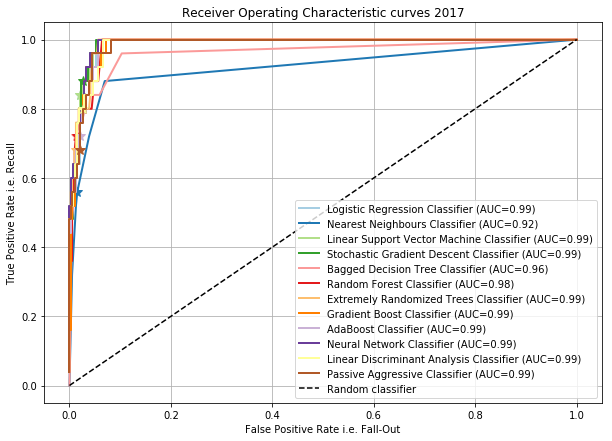

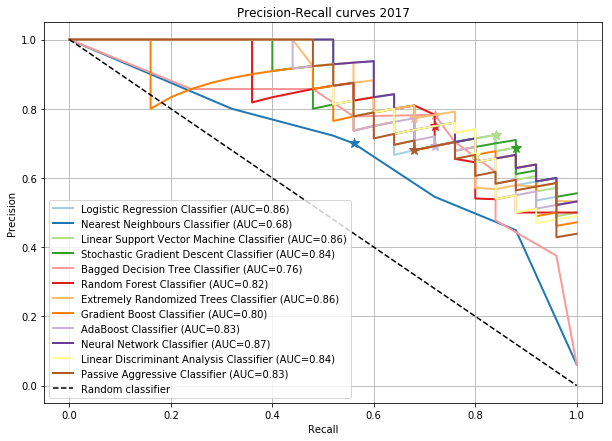

In [17]:
from matplotlib.pyplot import cm 
color=iter(cm.Paired(np.linspace(0,1,12))) #len(mymodels))))    

plt.figure(1, figsize=(10, 7))
plt.figure(2, figsize=(10, 7))

for mymodel in mymodels[:-1]: # Skip Voting Classifier: the predict_proba method is not available for 'hard' voting

    model     = mymodel.classifier
    modelname = mymodel.name

    print("==> Calculating ROC and PR curves using validation data for", modelname, "...")
    #print("")
    
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_validation)
        #elif hasattr(model, "decision_function"): # LogisticRegression, LinearSVC/SVC, PassiveAggressiveClassifier
    else:
        y_score = model.decision_function(X_validation)
    
    if hasattr(model, "predict_proba"):
        fpr_roc_curve, tpr_roc_curve, thresholds_roc_curve = roc_curve(y_validation, y_score[:, 1]) # to be used when y_score is calculated using predict_proba method
        #elif hasattr(model, "decision_function"): # LogisticRegression, LinearSVC/SVC, PassiveAggressiveClassifier
    else:
        fpr_roc_curve, tpr_roc_curve, thresholds_roc_curve = roc_curve(y_validation, y_score)       # to be used when y_score is calculated using decision_function method

    auc_roc_curve = auc(fpr_roc_curve, tpr_roc_curve)

    c=next(color)
    
    plt.figure(1)
    plt.plot(fpr_roc_curve, tpr_roc_curve, color=c, lw=2, label='{} (AUC={:.2f})'.format(modelname, auc_roc_curve))
    #plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random classifier')
    #plt.xlabel('False Positive Rate i.e. Fall-Out')
    #plt.ylabel('True Positive Rate i.e. Recall')
    #plt.title('Receiver Operating Characteristic curve {}'.format(validation_year))
    #plt.legend(loc="lower right")
    #plt.text(0.65, 0.3, r"ROC-AUC = {:.2f}".format(auc_roc_curve), color='red')
    #plt.grid(True)
    plt.plot(mymodel.fpr, mymodel.tpr, marker='*', color=c, markersize=10)
    
    if hasattr(model, "predict_proba"):
        precision_pr_curve, recall_pr_curve, thresholds_pr_curve = precision_recall_curve(y_validation, y_score[:, 1]) # to be used when y_score is calculated using predict_proba method
        #elif hasattr(model, "decision_function"): # LogisticRegression, LinearSVC/SVC, PassiveAggressiveClassifier
    else:
        precision_pr_curve, recall_pr_curve, thresholds_pr_curve = precision_recall_curve(y_validation, y_score)       # to be used when y_score is calculated using decision_function method

    auc_pr_curve = auc(recall_pr_curve, precision_pr_curve)

    plt.figure(2)
    plt.plot(recall_pr_curve, precision_pr_curve, color=c, lw=2, label='{} (AUC={:.2f})'.format(modelname, auc_pr_curve))
    #plt.plot([0, 1], [1, 0], color='black', linestyle='--', label='Random classifier')
    #plt.xlabel('Recall')
    #plt.ylabel('Precision')
    #plt.title('Precision-Recall curve {}'.format(validation_year))
    #plt.legend(loc="lower left")
    #plt.text(0.05, 0.3, r"PR-AUC = {:.2f}".format(auc_pr_curve), color='green')
    #plt.grid(True)
    plt.plot(mymodel.recall, mymodel.precision, marker='*', color=c, markersize=10)
    #plt.show()

plt.figure(1)
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random classifier')
plt.xlabel('False Positive Rate i.e. Fall-Out')
plt.ylabel('True Positive Rate i.e. Recall')
plt.title('Receiver Operating Characteristic curves {}'.format(validation_year))
plt.legend(loc="lower right")
plt.grid(True)

plt.figure(2)
plt.plot([0, 1], [1, 0], color='black', linestyle='--', label='Random classifier')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curves {}'.format(validation_year))
plt.legend(loc="lower left")
plt.grid(True)

Calculate feature importances of the fitted model (if applicable):

In [18]:
df_importances = pd.DataFrame(columns=modelnames, index=features)

for mymodel in mymodels:

    model     = mymodel.classifier
    modelname = mymodel.name

    print("--> Calculating feature importances for", modelname, "...")
    #print("")
    
    if hasattr(model, "feature_importances_"):
    
        importances = model.feature_importances_
        #indices = np.argsort(importances)[::-1]
    
        for i in range(X_training.shape[1]):
            #print("----> Feature importance ({:>2}) {:6} : {:.3f}".format(i + 1, features[indices[i]], importances[indices[i]]))
            df_importances.loc[features[i], modelname] = importances[i].round(3)*100
        
        #print("")
        
print("")
print("--> Feature importances of all models:")
print("")

display(HTML(df_importances.to_html()))

--> Calculating feature importances for Logistic Regression Classifier ...
--> Calculating feature importances for Nearest Neighbours Classifier ...
--> Calculating feature importances for Linear Support Vector Machine Classifier ...
--> Calculating feature importances for Stochastic Gradient Descent Classifier ...
--> Calculating feature importances for Bagged Decision Tree Classifier ...
--> Calculating feature importances for Random Forest Classifier ...
--> Calculating feature importances for Extremely Randomized Trees Classifier ...
--> Calculating feature importances for Gradient Boost Classifier ...
--> Calculating feature importances for AdaBoost Classifier ...
--> Calculating feature importances for Neural Network Classifier ...
--> Calculating feature importances for Linear Discriminant Analysis Classifier ...
--> Calculating feature importances for Passive Aggressive Classifier ...
--> Calculating feature importances for Voting Classifier ...

--> Feature importances of all 

,Logistic Regression Classifier,Nearest Neighbours Classifier,Linear Support Vector Machine Classifier,Stochastic Gradient Descent Classifier,Bagged Decision Tree Classifier,Random Forest Classifier,Extremely Randomized Trees Classifier,Gradient Boost Classifier,AdaBoost Classifier,Neural Network Classifier,Linear Discriminant Analysis Classifier,Passive Aggressive Classifier,Voting Classifier
G,NaN,NaN,NaN,NaN,NaN,0.9,1.6,2.2,0,NaN,NaN,NaN,NaN
GS/G,NaN,NaN,NaN,NaN,NaN,12.9,13.8,3.3,6,NaN,NaN,NaN,NaN
MP/G,NaN,NaN,NaN,NaN,NaN,12.6,9.8,7.7,12,NaN,NaN,NaN,NaN
3P,NaN,NaN,NaN,NaN,NaN,0.7,1.1,2.9,0,NaN,NaN,NaN,NaN
3PA,NaN,NaN,NaN,NaN,NaN,0.9,1,4,0,NaN,NaN,NaN,NaN
2P,NaN,NaN,NaN,NaN,NaN,5.2,8.7,5,0,NaN,NaN,NaN,NaN
2PA,NaN,NaN,NaN,NaN,NaN,4.2,8,2.6,0,NaN,NaN,NaN,NaN
FT,NaN,NaN,NaN,NaN,NaN,7.3,5.5,4.7,1,NaN,NaN,NaN,NaN
FTA,NaN,NaN,NaN,NaN,NaN,8.2,6.3,1.2,0,NaN,NaN,NaN,NaN
PF,NaN,NaN,NaN,NaN,NaN,1.4,1.3,3.7,5,NaN,NaN,NaN,NaN


Choose one of the classifiers in the list above:

In [19]:
classifier = 1

modelname = mymodels[classifier-1].name
model     = mymodels[classifier-1].classifier

print("--> Selected classifier =", modelname)
print("--> Model parameters : ", model.get_params())

--> Selected classifier = Logistic Regression Classifier
--> Model parameters :  {'C': 100, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


Calculate feature coefficients of the fitted model (if applicable):

In [20]:
'''
def logistic_function(x):
    return 1 / (1 + np.exp(-x))

from matplotlib.pyplot import cm 
color=iter(cm.tab20c(np.linspace(0,1,24)))    
'''
if hasattr(model, "coef_"): # i.e. LinearSVM, 
        
    print("--> Model coefficients: ")
    print("")
    
    #counter = 0
    for feature_name, feature_coef in zip(features, model.coef_.ravel()):
        print("----> Model coefficient {:6} ({:2}) = {:>6.3f}".format(feature_name, counter, feature_coef))
        
        '''
        #if (feature_name != 'GS/G'):
        #    counter += 1
        #    continue
        
        plt.figure(1, figsize=(8, 8))
        c='red' #next(color)
    
        #plt.clf()
        plt.scatter(X_training[feature_name].ravel(),  y_training.ravel(), color='blue',   zorder=20)
        X_test = np.linspace(-10, 10, 300)
    
        loss = logistic_function(X_test * abs(feature_coef) + model.intercept_).ravel()
        plt.plot(X_test, loss, color=c, linewidth=3, label=feature_name)

        plt.xlabel(feature_name)
        plt.ylabel('AS selection')
        plt.grid(True)
        plt.show()
        counter += 1
        '''
        
    #plt.xlabel('Feature')
    #plt.ylabel('AS selection')
    #plt.title('Logistic curves corresponding to data features')
    #plt.legend(loc="upper left")
    #plt.grid(True)

--> Model coefficients: 

----> Model coefficient G      (13) =  0.624
----> Model coefficient GS/G   (13) =  7.469
----> Model coefficient MP/G   (13) =  4.441
----> Model coefficient 3P     (13) =  1.043
----> Model coefficient 3PA    (13) = -1.579
----> Model coefficient 2P     (13) = -0.650
----> Model coefficient 2PA    (13) = -0.124
----> Model coefficient FT     (13) =  0.423
----> Model coefficient FTA    (13) = -0.469
----> Model coefficient PF     (13) = -1.037
----> Model coefficient PER    (13) =  2.357
----> Model coefficient ORB%   (13) = -0.148
----> Model coefficient DRB%   (13) =  0.367
----> Model coefficient AST%   (13) = -0.069
----> Model coefficient STL%   (13) = -0.439
----> Model coefficient BLK%   (13) =  0.466
----> Model coefficient TOV%   (13) =  0.586
----> Model coefficient USG%   (13) =  1.534
----> Model coefficient OWS    (13) = -0.303
----> Model coefficient DWS    (13) =  1.129
----> Model coefficient OBPM   (13) = -0.131
----> Model coefficient DBPM 

## Model predictions

Use fitted model to predict the NBA All-Stars in *prediction_year*, and calculate the corresponding confusion matrix:

--> Confusion matrix 2018:
[[369   3]
 [ 10  18]]

--> TP = 18, FP = 3, FN = 10, TN = 369

--> Precision (TP/(TP+FP)) = 85.7%
--> Recall    (TP/(TP+FN)) = 64.3%
--> F1 score               = 73.5%
--> Accuracy ((TP+TN)/TOT) = 96.8%


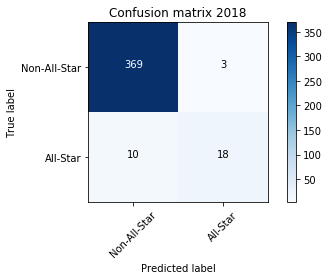

In [21]:
y_model = model.predict(X_prediction) # Use fitted model on prediction data

y_true = y_prediction.tolist()

CM = confusion_matrix(y_true, y_model) # defined as: rows -> true, columns -> prediction

print("--> Confusion matrix {}:".format(prediction_year))
print(CM)
print("")

TN = CM[0,0] # defined as: 0 = negative, 1 = positive
FN = CM[1,0] # defined as: 0 = negative, 1 = positive
FP = CM[0,1] # defined as: 0 = negative, 1 = positive
TP = CM[1,1] # defined as: 0 = negative, 1 = positive

TOT = TP + FP + FN + TN

print("--> TP = {}, FP = {}, FN = {}, TN = {}".format(TP, FP ,FN, TN))
print("")
    
print("--> Precision (TP/(TP+FP)) = {:5.1%}".format(TP/(TP+FP)))
print("--> Recall    (TP/(TP+FN)) = {:5.1%}".format(TP/(TP+FN)))
print("--> F1 score               = {:5.1%}".format(2*TP/(2*TP+FP+FN)))
print("--> Accuracy ((TP+TN)/TOT) = {:5.1%}".format((TP+TN)/TOT)) 
    
np.set_printoptions(precision=2)
class_names = ['Non-All-Star','All-Star']

plt.figure()
NBAanalysissetup.plot_confusion_matrix(CM, classes=class_names,
                                       title='Confusion matrix {}'.format(prediction_year))

#plt.figure()
#NBAanalysissetup.plot_confusion_matrix(CM, classes=class_names, normalize=True,
#                                       title='Normalized confusion matrix')   

Print classification report:

In [22]:
print("--> Classification report {}:".format(prediction_year))
print("")
class_names = ['Non-All-Stars (true)', 'All-Stars (true)']
print(classification_report(y_true, y_model, target_names=class_names))

--> Classification report 2018:

                      precision    recall  f1-score   support

Non-All-Stars (true)       0.97      0.99      0.98       372
    All-Stars (true)       0.86      0.64      0.73        28

         avg / total       0.97      0.97      0.97       400



Check which players are All-Stars according to the model:

In [23]:
TN_players = []
FP_players = []
FN_players = []
TP_players = []
    
for i in range(len(y_model)):
    
    player_name = df_prediction.iat[i,0] # 0-th column in df is player name
    
    if ((y_true[i] == 0) and (y_model[i] == 0)):   # TN
        TN_players.append(player_name)
    elif ((y_true[i] == 0) and (y_model[i] == 1)): # FP
        FP_players.append(player_name)
    elif ((y_true[i] == 1) and (y_model[i] == 0)): # FN
        FN_players.append(player_name)
    else:                                          # TP
        TP_players.append(player_name)
        
print("--> # of     All-Stars predicted to be     All-Stars = {:>3} (TP)".format(len(TP_players)))
print("--> # of     All-Stars predicted to be non-All-Stars = {:>3} (FN)".format(len(FN_players)))
print("--> # of non-All-Stars predicted to be     All-Stars = {:>3} (FP)".format(len(FP_players)))
print("--> # of non-All-Stars predicted to be non-All-Stars = {:>3} (TN)".format(len(TN_players)))
print("")
print("--> Deserved true All-Stars:     ", TP_players)
print("")
print("--> Questionable true All-Stars: ", FN_players)
print("")
print("--> Snubbed non-All-Stars:       ", FP_players)

--> # of     All-Stars predicted to be     All-Stars =  18 (TP)
--> # of     All-Stars predicted to be non-All-Stars =  10 (FN)
--> # of non-All-Stars predicted to be     All-Stars =   3 (FP)
--> # of non-All-Stars predicted to be non-All-Stars = 369 (TN)

--> Deserved true All-Stars:      ['LaMarcus Aldridge', 'Giannis Antetokounmpo', 'Jimmy Butler', 'DeMarcus Cousins', 'Stephen Curry', 'Anthony Davis', 'DeMar DeRozan', 'Andre Drummond', 'Kevin Durant', 'Joel Embiid', 'James Harden', 'Kyrie Irving', 'LeBron James', 'Damian Lillard', 'Victor Oladipo', 'Karl-Anthony Towns', 'John Wall', 'Russell Westbrook']

--> Questionable true All-Stars:  ['Bradley Beal', 'Goran Dragic', 'Paul George', 'Draymond Green', 'Al Horford', 'Kevin Love', 'Kyle Lowry', 'Kristaps Porzingis', 'Klay Thompson', 'Kemba Walker']

--> Snubbed non-All-Stars:        ['Clint Capela', 'Nikola Jokic', 'Chris Paul']


List all NBA players in *prediction_year* according to their model scores:

In [24]:
print("--> Model scores for top-50 players in {}:".format(prediction_year))
print("")

if hasattr(model, "decision_function"):
    y_score = model.decision_function(X_prediction)
else:
    y_score = model.predict_proba(X_prediction)
#y_score = model.predict_proba(X_prediction)
    
player_score_dict = {}
player_AS_dict    = {}

if includeadvancedstats:
    AS_index = 51
else:
    AS_index = 31
    
for i in range(len(y_model)):

    if hasattr(model, "decision_function"):
        player_score_dict[df_prediction.iat[i,0]] = y_score[i].ravel()[0]
    else:
        player_score_dict[df_prediction.iat[i,0]] = y_score[i].ravel()[1]
    #player_score_dict[df_prediction.iat[i,0]] = y_score[i].ravel()[1]
    
    if df_prediction.iat[i,AS_index] > 0.5:
        status = 'All-Star'
    else:
        status = 'Non-All-Star'
    player_AS_dict[df_prediction.iat[i,0]] = status
        
sorted_player_score_dict = sorted(player_score_dict.items(), key=operator.itemgetter(1), reverse=True)
    
counter = 0
printed_line = False
for key, value in dict(sorted_player_score_dict[:50]).items():
    counter += 1

    if hasattr(model, "decision_function"):
        if (value < 0 and not printed_line):
            print("**********************************************************")
            printed_line = True
    else:
        if (value < 0.5 and not printed_line):
            print("**********************************************************")
            printed_line = True

    #if (value < 0.5 and not printed_line):
    #    print("**********************************************************")
    #    printed_line = True
    print("----> {:3}: {:24} = {:.3f} ({})".format(counter, key, value, player_AS_dict[key]))

--> Model scores for top-50 players in 2018:

---->   1: James Harden             = 7.832 (All-Star)
---->   2: LeBron James             = 5.840 (All-Star)
---->   3: Kevin Durant             = 5.836 (All-Star)
---->   4: Anthony Davis            = 5.459 (All-Star)
---->   5: Stephen Curry            = 4.993 (All-Star)
---->   6: Damian Lillard           = 4.075 (All-Star)
---->   7: Giannis Antetokounmpo    = 3.922 (All-Star)
---->   8: Russell Westbrook        = 3.677 (All-Star)
---->   9: Kyrie Irving             = 3.340 (All-Star)
---->  10: DeMarcus Cousins         = 2.521 (All-Star)
---->  11: LaMarcus Aldridge        = 2.398 (All-Star)
---->  12: Joel Embiid              = 2.283 (All-Star)
---->  13: Karl-Anthony Towns       = 1.731 (All-Star)
---->  14: Victor Oladipo           = 1.403 (All-Star)
---->  15: Chris Paul               = 1.386 (Non-All-Star)
---->  16: DeMar DeRozan            = 0.801 (All-Star)
---->  17: Jimmy Butler             = 0.794 (All-Star)
---->  18: Clin

Print prediction features of any particular player:

## Ensemble model

Create an ensemble model from ML classifier list using *VotingClassifier* with majority voting:

In [25]:
classification_algs = []

for counter, mymodel in enumerate(mymodels, 1):
    if (0 < counter < 10):
        clf_tuple = (mymodel.name, mymodel.classifier)
        classification_algs.append(clf_tuple)
    
ensemble = VotingClassifier(estimators=classification_algs, voting='hard')

Cross-validate ensemble model:

In [26]:
cv_logo = logo.split(X_training, y_training, groups=cv_groups)

scores = cross_validate(ensemble, X_training, y_training, cv=cv_logo, scoring=scoring_list)
                                     
print("--> Cross-val years  :", ["{:6d}".format(yr) for yr in training_years])
print("")
print("--> Precision scores :", ["{:6.1%}".format(i) for i in scores['test_precision']])
print("--> Recall    scores :", ["{:6.1%}".format(i) for i in scores['test_recall'   ]])
print("--> F1        scores :", ["{:6.1%}".format(i) for i in scores['test_f1'       ]])
print("--> Accuracy  scores :", ["{:6.1%}".format(i) for i in scores['test_accuracy' ]])
print("")
print("--> Precision score : {:5.1%} +/- {:5.1%}".format(np.mean(scores['test_precision']), np.std(scores['test_precision'])))
print("--> Recall    score : {:5.1%} +/- {:5.1%}".format(np.mean(scores['test_recall'   ]), np.std(scores['test_recall'   ])))
print("--> F1 score        : {:5.1%} +/- {:5.1%}".format(np.mean(scores['test_f1'       ]), np.std(scores['test_f1'       ])))
print("--> Accuracy score  : {:5.1%} +/- {:5.1%}".format(np.mean(scores['test_accuracy' ]), np.std(scores['test_accuracy' ])))

--> Cross-val years  : ['  2000', '  2001', '  2002', '  2003', '  2004', '  2005', '  2006', '  2007', '  2008', '  2009', '  2010', '  2011', '  2012', '  2013', '  2014', '  2015', '  2016']

--> Precision scores : ['100.0%', ' 76.0%', ' 94.4%', ' 89.5%', ' 82.6%', ' 86.4%', ' 87.5%', ' 77.8%', ' 81.0%', ' 88.2%', ' 88.9%', ' 81.0%', ' 93.3%', ' 77.8%', ' 76.2%', ' 94.7%', ' 85.7%']
--> Recall    scores : [' 62.5%', ' 73.1%', ' 65.4%', ' 68.0%', ' 79.2%', ' 79.2%', ' 84.0%', ' 72.4%', ' 65.4%', ' 57.7%', ' 57.1%', ' 70.8%', ' 56.0%', ' 56.0%', ' 66.7%', ' 64.3%', ' 69.2%']
--> F1        scores : [' 76.9%', ' 74.5%', ' 77.3%', ' 77.3%', ' 80.9%', ' 82.6%', ' 85.7%', ' 75.0%', ' 72.3%', ' 69.8%', ' 69.6%', ' 75.6%', ' 70.0%', ' 65.1%', ' 71.1%', ' 76.6%', ' 76.6%']
--> Accuracy  scores : [' 97.6%', ' 96.5%', ' 97.4%', ' 97.2%', ' 97.6%', ' 97.9%', ' 98.3%', ' 96.5%', ' 96.6%', ' 96.6%', ' 96.4%', ' 97.2%', ' 97.0%', ' 96.3%', ' 96.9%', ' 97.4%', ' 97.3%']

--> Precision score : 85.9% 

Check which players are All-Stars according to the ensemble model:

In [27]:
ensemble.fit(X_training, y_training)     # Fit ensemble to training data

y_model = ensemble.predict(X_prediction) # Use fitted ensemble on prediction data

y_true = y_prediction.tolist()

TN_players = []
FP_players = []
FN_players = []
TP_players = []
    
for i in range(len(y_model)):
    
    player_name = df_prediction.iat[i,0] # 0-th column in df is player name
    
    if ((y_true[i] == 0) and (y_model[i] == 0)):   # TN
        TN_players.append(player_name)
    elif ((y_true[i] == 0) and (y_model[i] == 1)): # FP
        FP_players.append(player_name)
    elif ((y_true[i] == 1) and (y_model[i] == 0)): # FN
        FN_players.append(player_name)
    else:                                          # TP
        TP_players.append(player_name)
        
print("--> # of     All-Stars predicted to be     All-Stars = {:>3} (TP)".format(len(TP_players)))
print("--> # of     All-Stars predicted to be non-All-Stars = {:>3} (FN)".format(len(FN_players)))
print("--> # of non-All-Stars predicted to be     All-Stars = {:>3} (FP)".format(len(FP_players)))
print("--> # of non-All-Stars predicted to be non-All-Stars = {:>3} (TN)".format(len(TN_players)))
print("")
print("--> Deserved true All-Stars:     ", TP_players)
print("")
print("--> Questionable true All-Stars: ", FN_players)
print("")
print("--> Snubbed non-All-Stars:       ", FP_players)

--> # of     All-Stars predicted to be     All-Stars =  17 (TP)
--> # of     All-Stars predicted to be non-All-Stars =  11 (FN)
--> # of non-All-Stars predicted to be     All-Stars =   2 (FP)
--> # of non-All-Stars predicted to be non-All-Stars = 370 (TN)

--> Deserved true All-Stars:      ['LaMarcus Aldridge', 'Giannis Antetokounmpo', 'Jimmy Butler', 'DeMarcus Cousins', 'Stephen Curry', 'Anthony Davis', 'DeMar DeRozan', 'Andre Drummond', 'Kevin Durant', 'Joel Embiid', 'James Harden', 'Kyrie Irving', 'LeBron James', 'Damian Lillard', 'Victor Oladipo', 'Karl-Anthony Towns', 'Russell Westbrook']

--> Questionable true All-Stars:  ['Bradley Beal', 'Goran Dragic', 'Paul George', 'Draymond Green', 'Al Horford', 'Kevin Love', 'Kyle Lowry', 'Kristaps Porzingis', 'Klay Thompson', 'Kemba Walker', 'John Wall']

--> Snubbed non-All-Stars:        ['Nikola Jokic', 'Chris Paul']


Check classification results per classifier in the ensemble model:

In [28]:
y_classification = ensemble.transform(X_prediction) # Class labels predicted per classifier in ensemble

player_scores_dict    = {}
player_sumscores_dict = {}
        
for i in range(len(X_prediction)):
    player_name         = df_prediction.iat[i,0]
    classification_list = y_classification[i]
    classification_sum  = np.sum(classification_list)
    player_scores_dict   [player_name] = classification_list
    player_sumscores_dict[player_name] = classification_sum

sorted_player_sumscores_dict = sorted(player_sumscores_dict.items(), key=operator.itemgetter(1), reverse=True)

print("--> Sum of ML classifiers for top-50 players in {}:".format(prediction_year))
print("")

counter = 0
printed_line = False
for key, value in dict(sorted_player_sumscores_dict[:50]).items():
    counter += 1
    if (value < 5 and not printed_line):
        print("**************************************************************************")
        printed_line = True
    print("----> {:3}: {:24} = {:d} {} ({})".format(counter, key, value, player_scores_dict[key], player_AS_dict[key]))

--> Sum of ML classifiers for top-50 players in 2018:

---->   1: Giannis Antetokounmpo    = 9 [1 1 1 1 1 1 1 1 1] (All-Star)
---->   2: Jimmy Butler             = 9 [1 1 1 1 1 1 1 1 1] (All-Star)
---->   3: Anthony Davis            = 9 [1 1 1 1 1 1 1 1 1] (All-Star)
---->   4: DeMar DeRozan            = 9 [1 1 1 1 1 1 1 1 1] (All-Star)
---->   5: Kevin Durant             = 9 [1 1 1 1 1 1 1 1 1] (All-Star)
---->   6: Joel Embiid              = 9 [1 1 1 1 1 1 1 1 1] (All-Star)
---->   7: James Harden             = 9 [1 1 1 1 1 1 1 1 1] (All-Star)
---->   8: LeBron James             = 9 [1 1 1 1 1 1 1 1 1] (All-Star)
---->   9: Damian Lillard           = 9 [1 1 1 1 1 1 1 1 1] (All-Star)
---->  10: Karl-Anthony Towns       = 9 [1 1 1 1 1 1 1 1 1] (All-Star)
---->  11: Russell Westbrook        = 9 [1 1 1 1 1 1 1 1 1] (All-Star)
---->  12: LaMarcus Aldridge        = 8 [1 0 1 1 1 1 1 1 1] (All-Star)
---->  13: Stephen Curry            = 8 [1 1 1 1 1 0 1 1 1] (All-Star)
---->  14: Kyrie Irvin